### Some useful references:
1. **[Training]**: https://github.com/LIHANG-HONG/birdclef2023-2nd-place-solution
2. **[Inference]**: https://www.kaggle.com/code/kadircandrisolu/efficientnet-b0-pytorch-inference-birdclef-25

This model backbone is seresnext26t_32x4d

In [290]:
import os
import gc
import warnings
import logging
import time
import math
import cv2
from pathlib import Path
import joblib

import numpy as np
import pandas as pd
import librosa
import soundfile as sf
from soundfile import SoundFile 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import timm
from tqdm.auto import tqdm
from glob import glob
import torchaudio
import random
import itertools
from typing import Union

import concurrent.futures

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

In [291]:
class CFG:
    def __init__(self, mode="inference", kaggle_notebook=False):
        self.seed = 42
        self.print_freq = 100
        self.num_workers = 4
        self.stage = "train_bce"
        self.mode = mode  # "train" or "inference"

        if kaggle_notebook:
        # ===== Path Settings =====
            self.train_datadir = "/kaggle/input/birdclef-2025/train_audio"
            self.train_csv = "/kaggle/input/birdclef-2025/train.csv"
            self.test_soundscapes = "/kaggle/input/bc25-testsoundscapes-small"
            self.submission_csv = "/kaggle/input/birdclef-2025/sample_submission.csv"
            self.taxonomy_csv = "/kaggle/input/birdclef-2025/taxonomy.csv"
            self.model_files = ["/kaggle/input/bird2025-sed-ckpt/sedmodel.pth"]
            
        else:
            self.train_datadir = "/kaggle/input/birdclef-2025/train_audio"
            self.train_csv = "/kaggle/input/birdclef-2025/train.csv"
            self.test_soundscapes = "../data/raw/test_soundscapes/"
            self.submission_csv = "../data/raw/sample_submission.csv"
            self.taxonomy_csv = "../data/raw/taxonomy.csv"
            self.model_files = ["../models/sedmodel_0857/model_fold0.pth"]
            

        # ===== Model Settings =====
        self.model_name = "seresnext26t_32x4d"
        self.pretrained = False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.SR = 32000
        self.target_duration = 5
        self.train_duration = 10
        
        self.n_mels = 128
        self.n_fft = 2048
        self.hop_length = 512
        self.f_min = 20
        self.f_max = 16000
        self.normal = 80  # or 255
        self.infer_duration = 5
        self.duration_train = 10

        # ===== Device =====
        self.device = "cpu"

cfg = CFG(mode="inference", kaggle_notebook=False)

In [292]:
print(f"Using device: {cfg.device}")
print(f"Loading taxonomy data...")
taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
species_ids = taxonomy_df['primary_label'].tolist()
num_classes = len(species_ids)
print(f"Number of classes: {num_classes}")

Using device: cpu
Loading taxonomy data...
Number of classes: 206


In [293]:
def set_seed(seed=42):
    """
    Set seed for reproducibility
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.seed)


In [294]:
class AttBlockV2(nn.Module):
    def __init__(self, in_features: int, out_features: int, activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True,
        )
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True,
        )

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == "linear":
            return x
        elif self.activation == "sigmoid":
            return torch.sigmoid(x)


def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.0)

def init_bn(bn):
    bn.bias.data.fill_(0.0)
    bn.weight.data.fill_(1.0)

In [295]:

class BirdCLEFModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        
        taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
        self.num_classes = len(taxonomy_df)

        self.bn0 = nn.BatchNorm2d(cfg.n_mels)
        
        self.backbone = timm.create_model(
            cfg.model_name,
            pretrained=False,
            in_chans=cfg.in_channels,
            drop_rate=0.2,
            drop_path_rate=0.2,
        )

        layers = list(self.backbone.children())[:-2]
        self.encoder = nn.Sequential(*layers)
        
        if "efficientnet" in cfg.model_name:
            backbone_out = self.backbone.classifier.in_features
        elif "eca" in cfg.model_name:
            backbone_out = self.backbone.head.fc.in_features
        elif "res" in cfg.model_name:
            backbone_out = self.backbone.fc.in_features
        else:
            backbone_out = self.backbone.num_features
            
        self.fc1 = nn.Linear(backbone_out, backbone_out, bias=True)
        self.att_block = AttBlockV2(backbone_out, self.num_classes, activation="sigmoid")

        self.melspec_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=cfg.SR,
            hop_length=cfg.hop_length,
            n_mels=cfg.n_mels,
            f_min=cfg.f_min,
            f_max=cfg.f_max,
            n_fft=cfg.n_fft,
            pad_mode="constant",
            norm="slaney",
            onesided=True,
            mel_scale="htk",
        )
        if cfg.device == "cuda":
            self.melspec_transform = self.melspec_transform.cuda()
        else:
            self.melspec_transform = self.melspec_transform.cpu()

        self.db_transform = torchaudio.transforms.AmplitudeToDB(
            stype="power", top_db=80
        )

    def extract_feature(self, x):
        x = x.permute((0, 1, 3, 2))
        frames_num = x.shape[2]
        
        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        
        x = x.transpose(2, 3)
        x = self.encoder(x)
        
        x = torch.mean(x, dim=2)
        
        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        return x, frames_num
        
    @torch.cuda.amp.autocast(enabled=False)
    def transform_to_spec(self, audio):
        audio = audio.float()
        spec = self.melspec_transform(audio)
        spec = self.db_transform(spec)

        if self.cfg.normal == 80:
            spec = (spec + 80) / 80
        elif self.cfg.normal == 255:
            spec = spec / 255
        else:
            raise NotImplementedError
                
        if self.cfg.in_channels == 3:
            spec = image_delta(spec)
        
        return spec

    def forward(self, x):
        with torch.no_grad():
            x = self.transform_to_spec(x)

        x, frames_num = self.extract_feature(x)
        
        clipwise_output, norm_att, segmentwise_output = self.att_block(x)
        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        segmentwise_logit = self.att_block.cla(x).transpose(1, 2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        return torch.logit(clipwise_output)

    def infer(self, x, tta_delta=2):
        with torch.no_grad():
            x = self.transform_to_spec(x)
        x, _ = self.extract_feature(x)
        time_att = torch.tanh(self.att_block.att(x))
        feat_time = x.size(-1)

        start = (
            feat_time / 2 - feat_time * (self.cfg.infer_duration / self.cfg.duration_train) / 2
        )
        end = start + feat_time * (self.cfg.infer_duration / self.cfg.duration_train)
        start = int(start)
        end = int(end)
        pred = self.attention_infer(start, end, x, time_att)

        start_minus = max(0, start - tta_delta)
        end_minus = end - tta_delta
        pred_minus = self.attention_infer(start_minus, end_minus, x, time_att)

        start_plus = start + tta_delta
        end_plus = min(feat_time, end + tta_delta)
        pred_plus = self.attention_infer(start_plus, end_plus, x, time_att)

        pred = 0.5 * pred + 0.25 * pred_minus + 0.25 * pred_plus
        return pred
        
    def attention_infer(self, start, end, x, time_att):
        feat = x[:, :, start:end]
        framewise_pred = torch.sigmoid(self.att_block.cla(feat))
        framewise_pred_max = framewise_pred.max(dim=2)[0]
        return framewise_pred_max

In [296]:
def load_sample(path, cfg):
    audio, orig_sr = sf.read(path, dtype="float32")
    seconds = []
    audio_length = cfg.SR * cfg.target_duration
    step = audio_length
    for i in range(audio_length, len(audio) + step, step):
        start = max(0, i - audio_length)
        end = start + audio_length
        if end > len(audio):
            pass
        else:
            seconds.append(int(end/cfg.SR))

    audio = np.concatenate([audio,audio,audio])
    audios = []
    for i,second in enumerate(seconds):
        end_seconds = int(second)
        start_seconds = int(end_seconds - cfg.target_duration)
    
        end_index = int(cfg.SR * (end_seconds + (cfg.train_duration - cfg.target_duration) / 2) ) + len(audio) // 3
        start_index = int(cfg.SR * (start_seconds - (cfg.train_duration - cfg.target_duration) / 2) ) + len(audio) // 3
        end_pad = int(cfg.SR * (cfg.train_duration - cfg.target_duration) / 2) 
        start_pad = int(cfg.SR * (cfg.train_duration - cfg.target_duration) / 2) 
        y = audio[start_index:end_index].astype(np.float32)
        if i==0:
            y[:start_pad] = 0
        elif i==(len(seconds)-1):
            y[-end_pad:] = 0
        audios.append(y)

    return audios

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

In [297]:
def load_models(cfg, num_classes):
    """
    Load all model checkpoints from cfg.model_files and return initialized models
    """
    models = []
    model_files = cfg.model_files

    if not model_files:
        print(f"⚠️ No model files found under {cfg.model_path}!")
        return models

    print(f"🔍 Found {len(model_files)} model file(s).")

    for i, model_path in enumerate(model_files):
        try:
            print(f"📦 Loading model: {model_path}")

            checkpoint = torch.load(model_path, map_location=torch.device(cfg.device), weights_only=False)

            # checkpoint["cfg"] は dict の場合を想定して再構築
            if isinstance(checkpoint.get("cfg"), dict):
                cfg_dict = checkpoint["cfg"]
                cfg_temp = CFG()
                for k, v in cfg_dict.items():
                    setattr(cfg_temp, k, v)
            else:
                cfg_temp = checkpoint["cfg"]  # すでにCFGならそのまま使う

            cfg_temp.device = cfg.device  # 推論環境にあわせて上書き
            cfg_temp.taxonomy_csv = cfg.taxonomy_csv 

            model = BirdCLEFModel(cfg_temp)
            model.load_state_dict(checkpoint["model_state_dict"])
            
            model = model.to(cfg.device)
            model.eval()
            model.zero_grad()
            model.half().float()

            models.append(model)

        except Exception as e:
            print(f"❌ Error loading model {model_path}: {e}")

    return models

def predict_on_spectrogram(audio_path, models, cfg, species_ids):
    """Process a single audio file and predict species presence for each 5-second segment"""
    audio_path = str(audio_path)
    predictions = []
    row_ids = []
    soundscape_id = Path(audio_path).stem

    print(f"Processing {soundscape_id}")
    audio_data = load_sample(audio_path, cfg)
    for segment_idx, audio_input in enumerate(audio_data):
        
        end_time_sec = (segment_idx + 1) * cfg.target_duration
        row_id = f"{soundscape_id}_{end_time_sec}"
        row_ids.append(row_id)
        
        mel_spec = torch.tensor(audio_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        mel_spec = mel_spec.to(cfg.device)
        
        if len(models) == 1:
            with torch.no_grad():
                outputs = models[0].infer(mel_spec)
                final_preds = outputs.squeeze()
                # final_preds = torch.sigmoid(outputs).cpu().numpy().squeeze()

        else:
            segment_preds = []
            for model in models:
                with torch.no_grad():
                    outputs = model.infer(mel_spec)
                    probs = outputs.squeeze()
                    # probs = torch.sigmoid(outputs).cpu().numpy().squeeze()
                    segment_preds.append(probs)

            
            final_preds = np.mean(segment_preds, axis=0)
                
        predictions.append(final_preds)

    predictions = np.stack(predictions,axis=0)
    
    return row_ids, predictions

In [298]:
def run_inference(cfg, models, species_ids):
    """Run inference on all test soundscapes"""
    test_files = sorted(Path(cfg.test_soundscapes).glob('*.ogg'))
    
    print(f"Found {len(test_files)} test soundscapes")

    all_row_ids = []
    all_predictions = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
        results = list(
            executor.map(
                predict_on_spectrogram,
                test_files,
                itertools.repeat(models),
                itertools.repeat(cfg),
                itertools.repeat(species_ids)
            )
        )

    for rids, preds in results:
        all_row_ids.extend(rids)
        all_predictions.extend(preds)
    
    return all_row_ids, all_predictions

def create_submission(row_ids, predictions, species_ids, cfg):
    """Create submission dataframe"""
    print("Creating submission dataframe...")

    submission_dict = {'row_id': row_ids}
    
    for i, species in enumerate(species_ids):
        submission_dict[species] = [pred[i] for pred in predictions]

    submission_df = pd.DataFrame(submission_dict)

    submission_df.set_index('row_id', inplace=True)

    sample_sub = pd.read_csv(cfg.submission_csv, index_col='row_id')

    missing_cols = set(sample_sub.columns) - set(submission_df.columns)
    if missing_cols:
        print(f"Warning: Missing {len(missing_cols)} species columns in submission")
        for col in missing_cols:
            submission_df[col] = 0.0

    submission_df = submission_df[sample_sub.columns]

    submission_df = submission_df.reset_index()
    
    return submission_df


def smooth_submission(submission_path):
        """
        Post-process the submission CSV by smoothing predictions to enforce temporal consistency.
        
        For each soundscape (grouped by the file name part of 'row_id'), each row's predictions
        are averaged with those of its neighbors using defined weights.
        
        :param submission_path: Path to the submission CSV file.
        """
        print("Smoothing submission predictions...")
        sub = pd.read_csv(submission_path)
        cols = sub.columns[1:]
        # Extract group names by splitting row_id on the last underscore
        groups = sub['row_id'].str.rsplit('_', n=1).str[0].values
        unique_groups = np.unique(groups)
        
        for group in unique_groups:
            # Get indices for the current group
            idx = np.where(groups == group)[0]
            sub_group = sub.iloc[idx].copy()
            predictions = sub_group[cols].values
            new_predictions = predictions.copy()
            
            if predictions.shape[0] > 1:
                # Smooth the predictions using neighboring segments
                new_predictions[0] = (predictions[0] * 0.8) + (predictions[1] * 0.2)
                new_predictions[-1] = (predictions[-1] * 0.8) + (predictions[-2] * 0.2)
                for i in range(1, predictions.shape[0]-1):
                    new_predictions[i] = (predictions[i-1] * 0.2) + (predictions[i] * 0.6) + (predictions[i+1] * 0.2)
            # Replace the smoothed values in the submission dataframe
            sub.iloc[idx, 1:] = new_predictions
        
        sub.to_csv(submission_path, index=False)
        print(f"Smoothed submission saved to {submission_path}")

In [299]:

start_time = time.time()
print("Starting BirdCLEF-2025 inference...")

models = load_models(cfg, num_classes)

if not models:
    print("No models found! Please check model paths.")
    raise RuntimeError("No models loaded for inference.")

print(f"Model usage: {'Single model' if len(models) == 1 else f'Ensemble of {len(models)} models'}")

row_ids, predictions = run_inference(cfg, models, species_ids)

submission_df = create_submission(row_ids, predictions, species_ids, cfg)

submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Submission saved to {submission_path}")

smooth_submission(submission_path)

end_time = time.time()
print(f"Inference completed in {(end_time - start_time)/60:.2f} minutes")

Starting BirdCLEF-2025 inference...
🔍 Found 1 model file(s).
📦 Loading model: ../models/sedmodel_0857/model_fold0.pth


Model usage: Single model
Found 71 test soundscapes
Processing H02_20230420_074000
Processing H02_20230420_112000
Processing H02_20230420_154500
Processing H02_20230420_164000
Processing H02_20230420_223500
Processing H02_20230421_093000
Processing H02_20230421_113500
Processing H02_20230421_170000
Processing H02_20230421_190500
Processing H02_20230421_233500
Processing H02_20230422_014500
Processing H02_20230422_021500
Processing H02_20230422_024000
Processing H02_20230422_181000
Processing H02_20230422_212500
Processing H02_20230422_231000
Processing H02_20230423_111500
Processing H02_20230423_140000
Processing H02_20230423_151500
Processing H02_20230423_213500
Processing H02_20230423_222000
Processing H02_20230424_011500
Processing H02_20230424_025500
Processing H02_20230424_052000
Processing H02_20230424_055000
Processing H02_20230424_073500
Processing H02_20230424_075000
Processing H02_20230424_082000
Processing H02_20230424_182500
Processing H02_20230424_183000
Processing H02_202

In [300]:
pd.read_csv(submission_path)

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230420_074000_5,0.016332,0.012527,0.007972,0.004778,0.009133,0.009840,0.008630,0.012590,0.015284,...,0.007486,0.007325,0.009524,0.015557,0.006878,0.010789,0.009351,0.013137,0.017736,0.005246
1,H02_20230420_074000_10,0.008986,0.009379,0.005560,0.008420,0.007382,0.010534,0.009063,0.009051,0.012479,...,0.007712,0.006622,0.007708,0.012560,0.005736,0.012938,0.008207,0.013437,0.011326,0.008562
2,H02_20230420_074000_15,0.008765,0.013967,0.006337,0.010346,0.009861,0.009556,0.008770,0.009856,0.013425,...,0.008984,0.007204,0.008389,0.014169,0.006305,0.015094,0.009840,0.014444,0.011852,0.010935
3,H02_20230420_074000_20,0.009230,0.013817,0.005187,0.010118,0.011212,0.010011,0.008615,0.010036,0.013364,...,0.009529,0.007226,0.007192,0.016507,0.007442,0.015733,0.011343,0.014424,0.012735,0.011082
4,H02_20230420_074000_25,0.006668,0.008136,0.004723,0.014316,0.008138,0.011394,0.009380,0.007223,0.010487,...,0.009090,0.007163,0.006370,0.017960,0.007912,0.015926,0.012076,0.013338,0.012307,0.011930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,H02_20230502_080500_40,0.002336,0.001876,0.000957,0.000515,0.000806,0.004111,0.014697,0.003167,0.005528,...,0.020030,0.027711,0.006046,0.083873,0.012137,0.014495,0.050856,0.012915,0.037639,0.014520
848,H02_20230502_080500_45,0.001958,0.001380,0.000619,0.000446,0.000512,0.003708,0.015364,0.002588,0.004627,...,0.026780,0.030913,0.007797,0.127164,0.012345,0.018813,0.058853,0.018555,0.046434,0.018153
849,H02_20230502_080500_50,0.002502,0.001508,0.000689,0.000549,0.000445,0.003801,0.021782,0.003063,0.006434,...,0.030412,0.031240,0.008513,0.134912,0.010707,0.014256,0.081347,0.019558,0.046099,0.025409
850,H02_20230502_080500_55,0.002835,0.001733,0.001074,0.001084,0.000680,0.005114,0.020840,0.003364,0.007152,...,0.027195,0.027131,0.015060,0.098713,0.011500,0.010277,0.135707,0.014853,0.043887,0.021231


In [301]:
submission_sed = pd.read_csv("../data/result/submission_sed.csv")
submission_sed

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230420_074000_5,0.016332,0.012527,0.007971,0.004778,0.009133,0.009840,0.008630,0.012590,0.015284,...,0.007486,0.007325,0.009524,0.015557,0.006878,0.010789,0.009351,0.013137,0.017736,0.005246
1,H02_20230420_074000_10,0.008986,0.009379,0.005560,0.008420,0.007382,0.010534,0.009063,0.009051,0.012479,...,0.007712,0.006622,0.007708,0.012560,0.005736,0.012938,0.008207,0.013437,0.011326,0.008562
2,H02_20230420_074000_15,0.008765,0.013967,0.006337,0.010346,0.009861,0.009556,0.008770,0.009856,0.013425,...,0.008984,0.007204,0.008389,0.014169,0.006305,0.015094,0.009840,0.014444,0.011852,0.010935
3,H02_20230420_074000_20,0.009230,0.013817,0.005187,0.010118,0.011212,0.010011,0.008615,0.010036,0.013364,...,0.009529,0.007226,0.007192,0.016507,0.007442,0.015733,0.011343,0.014424,0.012735,0.011082
4,H02_20230420_074000_25,0.006668,0.008136,0.004723,0.014316,0.008138,0.011394,0.009380,0.007223,0.010487,...,0.009090,0.007163,0.006370,0.017960,0.007912,0.015926,0.012076,0.013338,0.012307,0.011930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,H02_20230421_233500_40,0.000622,0.000268,0.001013,0.002451,0.001090,0.002296,0.003640,0.000454,0.001321,...,0.002527,0.001519,0.000969,0.004996,0.000884,0.002199,0.000885,0.004323,0.002254,0.001449
116,H02_20230421_233500_45,0.000763,0.000345,0.001095,0.002011,0.001469,0.002735,0.004295,0.000625,0.001896,...,0.002756,0.001784,0.000969,0.004868,0.000828,0.002383,0.000867,0.005341,0.002152,0.001477
117,H02_20230421_233500_50,0.000901,0.000422,0.001033,0.001648,0.001985,0.002978,0.004607,0.000755,0.002246,...,0.002979,0.001832,0.000860,0.005548,0.000813,0.002539,0.000884,0.005650,0.002346,0.001361
118,H02_20230421_233500_55,0.000946,0.000494,0.000867,0.001378,0.001661,0.003114,0.005149,0.000810,0.002382,...,0.003257,0.002210,0.000919,0.006803,0.000824,0.002699,0.001130,0.005487,0.002700,0.001394


In [302]:
assert cfg.test_soundscapes == "/kaggle/input/birdclef-2025/test_soundscapes", "Test_soundscapes path is incorrect!"

AssertionError: Test_soundscapes path is incorrect!

In [ ]:
# 必要な前処理：インデックス化と共通部分抽出
df1 = submission_df.set_index('row_id').sort_index()
df2 = submission_sed.set_index('row_id').sort_index()

# 共通の row_id & species（列）を使う
common_rows = df1.index.intersection(df2.index)
common_cols = df1.columns.intersection(df2.columns)

df1 = df1.loc[common_rows, common_cols]
df2 = df2.loc[common_rows, common_cols]

# 閾値を超える部分を「検出された」とみなす（例: 0.5）
threshold = 0.5
det1 = (df1 > threshold).astype(int)
det2 = (df2 > threshold).astype(int)

# 各行において一致したかどうか（1: 両方で検出 or 両方で未検出, 0: 一方のみ）
match_matrix = (det1 == det2).astype(int)

# 全体一致率（全行×全種で一致した割合）
match_rate = match_matrix.values.mean()

print(f"✅ 全体一致率: {match_rate:.4f}（1に近いほど類似）")

# 部分的に一致しているか（IoU風）
intersection = ((det1 + det2) == 2).sum().sum()
union = ((det1 + det2) >= 1).sum().sum()
iou = intersection / union if union > 0 else 0.0

print(f"🔁 IoU (一致領域 / 合計領域): {iou:.4f}")



✅ 全体一致率: 0.9992（1に近いほど類似）
🔁 IoU (一致領域 / 合計領域): 0.8131


In [ ]:
# 表示したい行数だけ制限（長すぎると見にくいため）
max_display = 100  # 必要に応じて変更

for row_id in common_rows[:max_display]:
    detected_1 = df1.loc[row_id][df1.loc[row_id] > threshold].index.tolist()
    detected_2 = df2.loc[row_id][df2.loc[row_id] > threshold].index.tolist()

    print(f"🟢 Row ID: {row_id}")
    print(f"  - submission_df     : {detected_1}")
    print(f"  - submission_sed    : {detected_2}")
    
    # 共通・差分を出す
    only_in_1 = set(detected_1) - set(detected_2)
    only_in_2 = set(detected_2) - set(detected_1)
    intersection = set(detected_1) & set(detected_2)

    print(f"    ✅ 共通: {sorted(intersection)}")
    print(f"    ➕ submission_df のみ: {sorted(only_in_1)}")
    print(f"    ➕ submission_sed のみ: {sorted(only_in_2)}")
    print("-" * 80)

🟢 Row ID: H02_20230420_074000_10
  - submission_df     : []
  - submission_sed    : []
    ✅ 共通: []
    ➕ submission_df のみ: []
    ➕ submission_sed のみ: []
--------------------------------------------------------------------------------
🟢 Row ID: H02_20230420_074000_15
  - submission_df     : []
  - submission_sed    : []
    ✅ 共通: []
    ➕ submission_df のみ: []
    ➕ submission_sed のみ: []
--------------------------------------------------------------------------------
🟢 Row ID: H02_20230420_074000_20
  - submission_df     : []
  - submission_sed    : []
    ✅ 共通: []
    ➕ submission_df のみ: []
    ➕ submission_sed のみ: []
--------------------------------------------------------------------------------
🟢 Row ID: H02_20230420_074000_25
  - submission_df     : []
  - submission_sed    : []
    ✅ 共通: []
    ➕ submission_df のみ: []
    ➕ submission_sed のみ: []
--------------------------------------------------------------------------------
🟢 Row ID: H02_20230420_074000_30
  - submission_df     :

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(det1.sum(axis=1), label="submission_df", alpha=0.7)
plt.plot(det2.sum(axis=1) + 0.1, label="submission_sed (+0.1 offset)", alpha=0.7)  # 少し上にずらす
plt.title("検出された species 数（各5秒区間）")
plt.xlabel("Time segment index")
plt.ylabel("Detected species count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

matched_species_count = (det1 & det2).sum(axis=1)

plt.figure(figsize=(12, 5))
plt.plot(matched_species_count, label="Matched species count", color='green')
plt.title("一致した species 数（各5秒区間）")
plt.xlabel("Time segment index")
plt.ylabel("Matched species count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

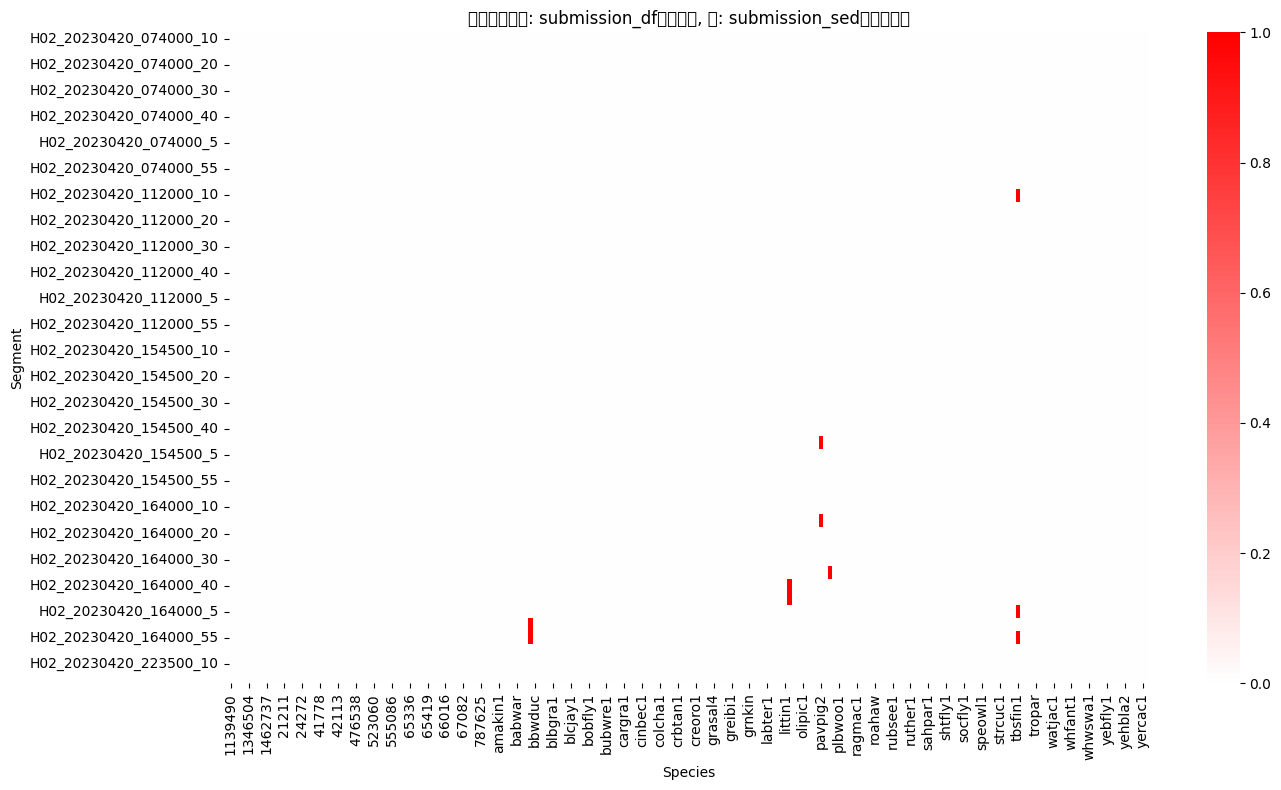

In [ ]:
import seaborn as sns
# 例：最初の N セグメントだけ可視化（行数が多すぎるため）
subset_rows = common_rows[:50]

plt.figure(figsize=(14, 8))
sns.heatmap((det1.loc[subset_rows] - det2.loc[subset_rows]), cmap='bwr', center=0, cbar=True)
plt.title("検出差分（赤: submission_dfのみ検出, 青: submission_sedのみ検出）")
plt.xlabel("Species")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()